# Introduction<br>
In business, employee attrition is when employees leave the company for whatever reason, either they've found a new job or retired, and haven't been replaced immediately.<br><br>

For a company to be successful, it needs not only to attract top talent but it also needs to retain these talents. For this reason, I have the job to look into a dataset containing information regarding a certain company's employee list to try to find patterns that may provide useful information in understanding why employees leave. <br><br>

After an EDA, I'll build a machine learning model for employee attrition prediction.

In [9]:
# Importing libraries
import pandas as pd, numpy as np, seaborn as sns, plotly.express as px, xgboost as XGB, matplotlib.pyplot as plt,plotly.graph_objects as go, math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [10]:
# Plot Customization
plt.figure(figsize = (15,9))
plt.style.context('bmh')

<Figure size 1080x648 with 0 Axes>

In [11]:
# Loading dataset
df = pd.read_csv('Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [12]:
# Information on dataset
print(f'The dataset has {df.shape[0]} rows for each employee and {df.shape[1]} attributes\n')
print('='*80)
print('The attributes and their unique values are as below\n')
for i in df.columns:
    print(f'======== {i} ========\n')
    print(df[i].value_counts().sort_values(ascending=False))
    print('- - ' * 20)

The dataset has 1470 rows for each employee and 35 attributes

The attributes and their unique values are as below

======== Age ========

35    78
34    77
36    69
31    69
29    68
32    61
30    60
33    58
38    58
40    57
37    50
27    48
28    48
42    46
39    42
45    41
41    40
26    39
44    33
46    33
43    32
50    30
25    26
24    26
49    24
47    24
55    22
51    19
53    19
48    19
54    18
52    18
22    16
56    14
23    14
58    14
21    13
20    11
59    10
19     9
18     8
60     5
57     4
Name: Age, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== Attrition ========

No     1233
Yes     237
Name: Attrition, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== BusinessTravel ========

Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [13]:
# Dropping columns with little to no useful information
df = df.drop(['EmployeeCount',
                 'EmployeeNumber',
                 'Over18',
                  'StandardHours'],axis = 1)
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [14]:
df.dtypes

Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance              int64
YearsAtCompany               int64
YearsInCurrentRole  

In [15]:
# Unencoding Categorical Features
col = ['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','RelationshipSatisfaction']

for i in df['Education']:
    df['Education'].replace({1:'Below College',2:'College',3:'Bachelor',4:'Master', 5:'Doctor'},
                       inplace = True)
    
for i in df['PerformanceRating']:
    df['PerformanceRating'].replace({1:'Low', 2:'Good',3:'Excellent',4:'Outstanding'},
                                  inplace = True)
    
for i in df['WorkLifeBalance']:
    df['WorkLifeBalance'].replace({1: 'Bad', 2:'Good', 3:'Better', 4:'Best'}, 
                                  inplace = True)

for i in df[col]:
    df[i].replace({1:'Low', 2:'Medium',3:'High', 4:'Very High'},
                   inplace = True)

In [16]:
# Checking new values for decoded attributes 
decoded = ['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','RelationshipSatisfaction',
           'Education', 'PerformanceRating', 'WorkLifeBalance']

for i in df[decoded]:
    print(f'======== {i} ========\n')
    print(df[i].value_counts().sort_values(ascending=False))
    print('- - ' * 20)

======== EnvironmentSatisfaction ========

High         453
Very High    446
Medium       287
Low          284
Name: EnvironmentSatisfaction, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== JobInvolvement ========

High         868
Medium       375
Very High    144
Low           83
Name: JobInvolvement, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== JobSatisfaction ========

Very High    459
High         442
Low          289
Medium       280
Name: JobSatisfaction, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== RelationshipSatisfaction ========

High         459
Very High    432
Medium       303
Low          276
Name: RelationshipSatisfaction, dtype: int64
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
======== Education ========

Bachelor         572
Master           398
College          

*JobLevel* doesn't have a description containing its values, so I'll leave them numeric, just as they've been originally collected.

In [17]:
# Checking for missing data
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [18]:
# Visualizing target variable classes and its distribution among the dataset
fig = px.pie(df, names = 'Attrition', title = 'Target Variable: Attrition', template = 'plotly_dark')
fig.update_traces(rotation=90, pull = [0.1], textinfo = "percent+label")
fig.show()

# Data Visualization and EDA

To help in visualizing characteristics and try to find useful patterns, I'll create a separate dataframe containing only employees who've left the organization.

In [19]:
Attrition = df.query("Attrition == 'Yes'")
Attrition

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,College,Life Sciences,Medium,Female,...,Excellent,Low,0,8,0,Bad,6,4,0,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,College,Other,Very High,Male,...,Excellent,Medium,0,7,3,Better,0,0,0,0
14,28,Yes,Travel_Rarely,103,Research & Development,24,Bachelor,Life Sciences,High,Male,...,Excellent,Medium,0,6,4,Better,4,2,0,3
21,36,Yes,Travel_Rarely,1218,Sales,9,Master,Life Sciences,High,Male,...,Outstanding,Medium,0,10,4,Better,5,3,0,3
24,34,Yes,Travel_Rarely,699,Research & Development,6,Below College,Medical,Medium,Male,...,Excellent,High,0,8,2,Better,4,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,23,Yes,Travel_Frequently,638,Sales,9,Bachelor,Marketing,Very High,Male,...,Excellent,Low,1,1,3,Good,1,0,1,0
1442,29,Yes,Travel_Rarely,1092,Research & Development,1,Master,Medical,Low,Male,...,Excellent,Medium,3,4,3,Best,2,2,2,2
1444,56,Yes,Travel_Rarely,310,Research & Development,7,College,Technical Degree,Very High,Male,...,Excellent,Very High,1,14,4,Bad,10,9,9,8
1452,50,Yes,Travel_Frequently,878,Sales,1,Master,Life Sciences,Medium,Male,...,Excellent,Very High,2,12,3,Better,6,3,0,1


In [20]:
print(f"{Attrition.shape[0]} emplyees in the dataset left the company.\n")
print("Let's try to find some more information about them!")

237 emplyees in the dataset left the company.

Let's try to find some more information about them!


In [21]:
# Creating a function to plot histograms
def barplot(i):
    fig = px.histogram(Attrition, x = Attrition[i], template = 'plotly_dark',
                      title = f'Attrition x {i}', text_auto = 'd3-format')
    fig.show()

In [22]:
# Creating visualizations for categorical values
barplot('BusinessTravel')
barplot('Department')
barplot('Education')
barplot('EnvironmentSatisfaction')
barplot('EducationField')
barplot('Gender')
barplot('JobInvolvement')
barplot('JobSatisfaction')
barplot('WorkLifeBalance')
barplot('PerformanceRating')
barplot('JobRole')
barplot('MaritalStatus')
barplot('RelationshipSatisfaction')
barplot('OverTime')

In [23]:
# Creating a function to plot histograms on numeric features
def numeric_plot(i):
    fig = px.histogram(Attrition, x = Attrition[i], nbins  = 20, template = 'plotly_dark',
                      title = f'Attrition x {i}')
    fig.show()

In [24]:
numeric_plot('Age')
numeric_plot('DailyRate')
numeric_plot('DistanceFromHome')
numeric_plot('HourlyRate')
numeric_plot('JobLevel')
numeric_plot('MonthlyIncome')
numeric_plot('MonthlyRate')
numeric_plot('NumCompaniesWorked')
numeric_plot('PercentSalaryHike')
numeric_plot('StockOptionLevel')
numeric_plot('TotalWorkingYears')
numeric_plot('TrainingTimesLastYear')
numeric_plot('YearsAtCompany')
numeric_plot('YearsInCurrentRole')
numeric_plot('YearsSinceLastPromotion')
numeric_plot('YearsWithCurrManager')

## EDA Conclusions
#### Categorical Variables<br><br>
When analyzing categorical variables, we can see that most employees who have left worked for the **Research & Development department**, with most of them being **laboratory technicians**, **sales executives** or **research scientists**.<br><br>

It's noticable that **these employees scored excellent performance ratings**. It isn't good to lose employees with such performance levels at all!<br><br>

Most of them had a **Bachelor's degree** and their **education field** was mostly either **Life Sciences**, **Medical** and **Marketing**.<br><br>

These employee majoraly presented high job involvement, and high satisfcation with their job, and also a better work life balance, but **it's preoccupying that a large amount of them said they've had a low satisfaction with the work environment**.<br><br>

How can we make the work environment better? What kind of changes must be done, especially for the research and development personel? These are important questions to be asked. <br><br>

#### Numerical Variables <br><br>
Looking at the attrition per age histogram, It's noticeable that **as employees grow old, the less they tend to leave**, and most of our employee attrition is made of employees ranging from 25 to 35 years old. The data also shows that **the more working years, more years at the company, and more years in current role employees accumulate, the less likely they are to leave**.<br><br>

When it comes to income, **the majority of employees who have left were among those with the smaller monthly income**, with a monthly income varying from 2.000 to 3.000. **Those who've less percent salary hike also tend to leave** more than those with a higher percentual hike in salary. <br><br>

So mostly, **employees who leave tend to be young**, with less time working in the company and **at the beginning of their career in general**, since most of these employees were working for less than 10 years in total. <br><br>

It's also curious to see that **a lot of these employees had less than 2 years working with their last manager**. This reminds me of the number of employees who said that their satisfaction with the work environment was low. Could we be having issues with some managers? How well are they trained to deal with their teams and the people they led? Are we, as a company doing the best we can to assure a good relationship between managers and teams? 

# Employee Attrition Prediction

After looking at our data and identifying some information on employee attrition, it's time to run some classification models to try to predict when employees are more likely to leave.

In [25]:
# Splitting Dataset
X = df.drop('Attrition', axis = 1)
y = df.Attrition

In [26]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)
print('X train size: ', len(X_train))
print('X test size: ', len(X_test))
print('y train size: ', len(y_train))
print('y test size: ', len(y_test))

X train size:  1029
X test size:  441
y train size:  1029
y test size:  441


The next step is encoding all categorical variables and I'll use both the Ordinal Encoder and the One Hot Encoder to do that.<br><br>

It's important to remember that **the Ordinal Encoder assumes an ordering of categories**. So, for instance, when encoding Relationship Satisfaction, **the encoding will assume that 'Low (0)' is lesser than 'Very High(3)'**.<br><br>

The One Hot Encoder, on the other way, will create new columns indicating the presence or absence of each possible value for every categorical attribute in our dataset, with binary values where **0 indicates the absence of each value and 1 indicates the presence of each value**. <br><br>

Categories such as Education and Job Involvement can easily be encoded with the Ordinal Encoder since there is some sort of **hierarchy** among their values, but Department, for instance, would be better encoded with the One Hot Encoder, since there is no department lesser or more than another.

In [27]:
# Enoding categorical variables with Ordinal Encoder
OE = OrdinalEncoder()
columns_OE = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
             'JobSatisfaction','WorkLifeBalance','PerformanceRating','RelationshipSatisfaction']
X_train[columns_OE] = OE.fit_transform(X_train[columns_OE])
X_test[columns_OE] = OE.transform(X_test[columns_OE])
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
17,22,0.0,1123,Research & Development,16,2.0,Medical,3.0,Male,96,...,0.0,2.0,2,1,2,3.0,1,0,0,0
336,29,2.0,318,Research & Development,8,4.0,Other,2.0,Male,77,...,0.0,3.0,0,7,4,3.0,7,7,0,7
1110,35,2.0,104,Research & Development,2,0.0,Life Sciences,1.0,Female,69,...,0.0,3.0,1,1,2,2.0,1,0,0,0
199,38,2.0,1084,Research & Development,29,0.0,Technical Degree,3.0,Male,54,...,0.0,1.0,1,9,3,0.0,7,7,1,7
1225,45,2.0,1005,Research & Development,28,2.0,Technical Degree,3.0,Female,48,...,0.0,0.0,0,21,2,2.0,21,6,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,39,2.0,116,Research & Development,24,1.0,Life Sciences,1.0,Male,52,...,0.0,1.0,0,18,2,2.0,7,7,1,7
252,29,2.0,665,Research & Development,15,0.0,Life Sciences,0.0,Male,60,...,0.0,1.0,0,6,1,2.0,6,5,1,5
707,47,1.0,1379,Research & Development,16,4.0,Medical,0.0,Male,64,...,0.0,0.0,0,20,3,1.0,19,10,2,7
182,41,2.0,1356,Sales,20,2.0,Marketing,2.0,Female,70,...,1.0,3.0,0,4,5,3.0,4,3,0,2


In [28]:
# Transforming bicategoric variables into binary values
X_train['OverTime'].replace({'Yes': 1,
                                      'No':0}, inplace=True)
X_test['OverTime'].replace({'Yes': 1,
                                      'No':0}, inplace=True)
X_train['Gender'].replace({'Male': 1,
                                      'Female':0}, inplace=True)
X_test['Gender'].replace({'Male': 1,
                                      'Female':0}, inplace=True)

In [29]:
X_train.OverTime.value_counts()

0    732
1    297
Name: OverTime, dtype: int64

In [30]:
X_test.Gender.value_counts()

1    253
0    188
Name: Gender, dtype: int64

In [31]:
X_train

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
17,22,0.0,1123,Research & Development,16,2.0,Medical,3.0,1,96,...,0.0,2.0,2,1,2,3.0,1,0,0,0
336,29,2.0,318,Research & Development,8,4.0,Other,2.0,1,77,...,0.0,3.0,0,7,4,3.0,7,7,0,7
1110,35,2.0,104,Research & Development,2,0.0,Life Sciences,1.0,0,69,...,0.0,3.0,1,1,2,2.0,1,0,0,0
199,38,2.0,1084,Research & Development,29,0.0,Technical Degree,3.0,1,54,...,0.0,1.0,1,9,3,0.0,7,7,1,7
1225,45,2.0,1005,Research & Development,28,2.0,Technical Degree,3.0,0,48,...,0.0,0.0,0,21,2,2.0,21,6,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,39,2.0,116,Research & Development,24,1.0,Life Sciences,1.0,1,52,...,0.0,1.0,0,18,2,2.0,7,7,1,7
252,29,2.0,665,Research & Development,15,0.0,Life Sciences,0.0,1,60,...,0.0,1.0,0,6,1,2.0,6,5,1,5
707,47,1.0,1379,Research & Development,16,4.0,Medical,0.0,1,64,...,0.0,0.0,0,20,3,1.0,19,10,2,7
182,41,2.0,1356,Sales,20,2.0,Marketing,2.0,0,70,...,1.0,3.0,0,4,5,3.0,4,3,0,2


In [32]:
# Enoding categorical variables with One Hot Encoder
OHE = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
columns_OHE = ['Department', 'EducationField', 'JobRole', 'MaritalStatus']
X_train_cols = pd.DataFrame(OHE.fit_transform(X_train[columns_OHE]))
X_test_cols = pd.DataFrame(OHE.transform(X_test[columns_OHE]))
# Putting index back
X_train_cols.index = X_train.index
X_test_cols.index = X_test.index
# Removing categorical columns
num_X_train = X_train.drop([col for col in X_train.columns if X_train[col].dtype == "object"], axis = 1)
num_X_test = X_test.drop([col for col in X_test.columns if X_test[col].dtype == "object"], axis = 1)
# Adding one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train,X_train_cols ],axis = 1)
X_test = pd.concat([num_X_test, X_test_cols], axis = 1)

In [33]:
X_train

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,11,12,13,14,15,16,17,18,19,20
17,22,0.0,1123,16,2.0,3.0,1,96,3.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
336,29,2.0,318,8,4.0,2.0,1,77,1.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1110,35,2.0,104,2,0.0,1.0,0,69,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
199,38,2.0,1084,29,0.0,3.0,1,54,0.0,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1225,45,2.0,1005,28,2.0,3.0,0,48,2.0,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,39,2.0,116,24,1.0,1.0,1,52,0.0,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
252,29,2.0,665,15,0.0,0.0,1,60,0.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
707,47,1.0,1379,16,4.0,0.0,1,64,3.0,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
182,41,2.0,1356,20,2.0,2.0,0,70,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [34]:
# Rescaling Data
Scaler = MinMaxScaler()
Scaling_Cols = ['TrainingTimesLastYear','YearsAtCompany','TotalWorkingYears',
               'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager',
               'PercentSalaryHike','Age','DailyRate','DistanceFromHome','HourlyRate',
               'MonthlyIncome','MonthlyRate','NumCompaniesWorked']
X_train[Scaling_Cols] = Scaler.fit_transform(X_train[Scaling_Cols])
X_test[Scaling_Cols] = Scaler.transform(X_test[Scaling_Cols])
X_train

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,11,12,13,14,15,16,17,18,19,20
17,0.095238,0.0,0.730852,0.535714,2.0,3.0,1,0.942857,3.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
336,0.261905,2.0,0.154617,0.250000,4.0,2.0,1,0.671429,1.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1110,0.404762,2.0,0.001432,0.035714,0.0,1.0,0,0.557143,0.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
199,0.476190,2.0,0.702935,1.000000,0.0,3.0,1,0.342857,0.0,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1225,0.642857,2.0,0.646385,0.964286,2.0,3.0,0,0.257143,2.0,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,0.500000,2.0,0.010021,0.821429,1.0,1.0,1,0.314286,0.0,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
252,0.261905,2.0,0.403006,0.500000,0.0,0.0,1,0.428571,0.0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
707,0.690476,1.0,0.914102,0.535714,4.0,0.0,1,0.485714,3.0,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
182,0.547619,2.0,0.897638,0.678571,2.0,2.0,0,0.571429,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [35]:
# Changing y values
print(y_train.value_counts())
print(y_test.value_counts())

No     861
Yes    168
Name: Attrition, dtype: int64
No     372
Yes     69
Name: Attrition, dtype: int64


In [36]:
y_train.replace({'No':0,
                'Yes':1}, inplace = True)
y_test.replace({'No':0,
                'Yes':1}, inplace = True)

In [40]:
print(y_train.value_counts())
print(y_test.value_counts())

0    861
1    168
Name: Attrition, dtype: int64
0    372
1     69
Name: Attrition, dtype: int64


We've seen before that **our target variable is unbalanced**, with much more 'No' values than 'Yes'.<br><br>

I'll use **SMOTE to synthetically create more 'Yes' values and have a 50/50 distribution** for both classes during training. I prefer to oversample our minor class than undersampling the major class because I believe that **undersampling may cause a loss of relevant data**.

In [44]:
# Dealing with Class Imbalance using SMOTE
from imblearn.over_sampling import SMOTE
X_train,y_train = SMOTE().fit_resample(X_train,y_train)

AttributeError: module 'sklearn.metrics._dist_metrics' has no attribute 'DatasetsPair'

In [42]:
y_train.value_counts()

0    861
1    168
Name: Attrition, dtype: int64

In [ ]:
# Importing Models
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
adaboost = AdaBoostClassifier()
randomforest = RandomForestClassifier()
gradientboosting = GradientBoostingClassifier()
decisiontree = DecisionTreeClassifier()
xgboost =  XGBClassifier()

In [ ]:
# Creating a function for predictions
def predict(model):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_predict) * 100 ))
    print('Precision: %.2f%%' % (precision_score(y_test, y_predict) * 100))
    print('Recall: %.2f%%' % (recall_score(y_test, y_predict) * 100))
    print('F1_Score: %.2f%%' % (f1_score(y_test, y_predict) * 100))
    confusion_matrix_model = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(12,8))
    ax = plt.subplot()
    sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_title(f'Confusion Matrix - {model}')
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

Accuracy: 74.38%
Precision: 29.00%
Recall: 40.85%
F1_Score: 33.92%


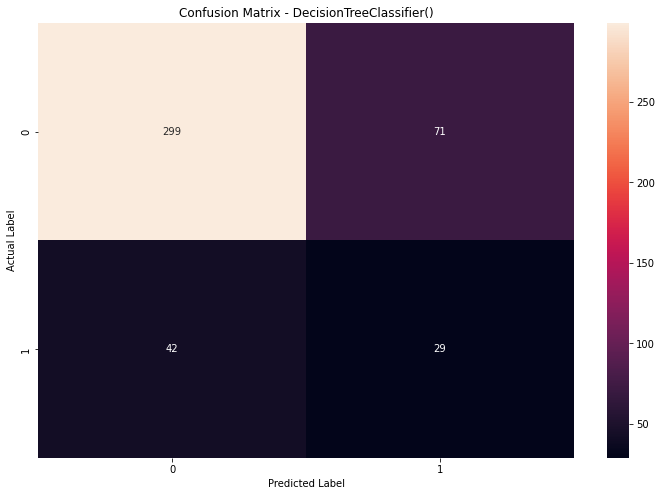

In [ ]:
# Decision Tree
predict(decisiontree)

#### Ensemble Methods

Accuracy: 84.81%
Precision: 55.56%
Recall: 28.17%
F1_Score: 37.38%


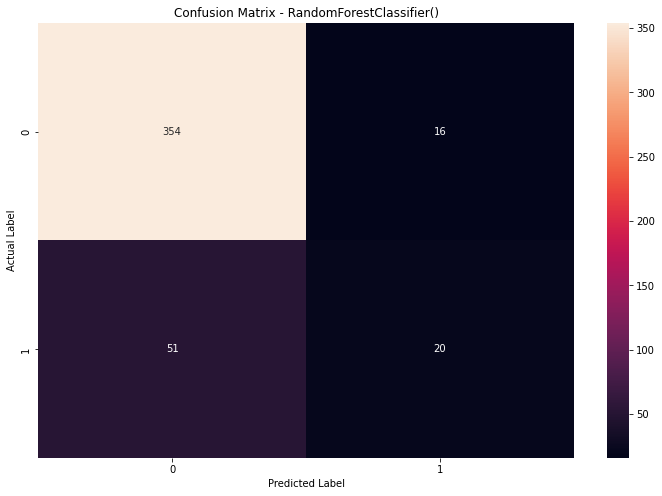

In [ ]:
predict(randomforest)

Accuracy: 82.31%
Precision: 45.68%
Recall: 52.11%
F1_Score: 48.68%


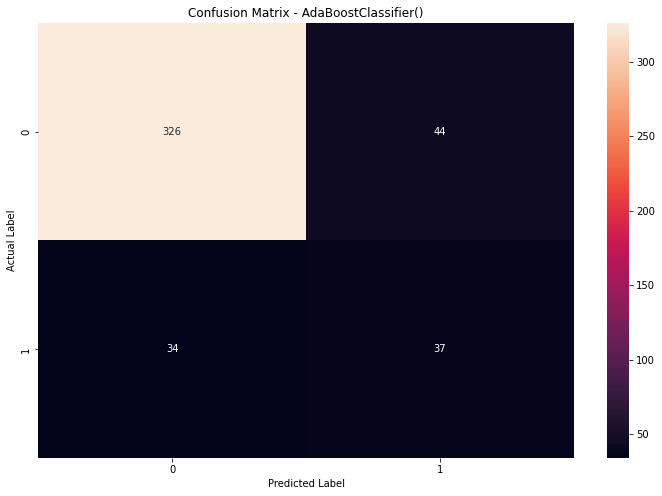

In [ ]:
predict(adaboost)

Accuracy: 86.39%
Precision: 61.22%
Recall: 42.25%
F1_Score: 50.00%


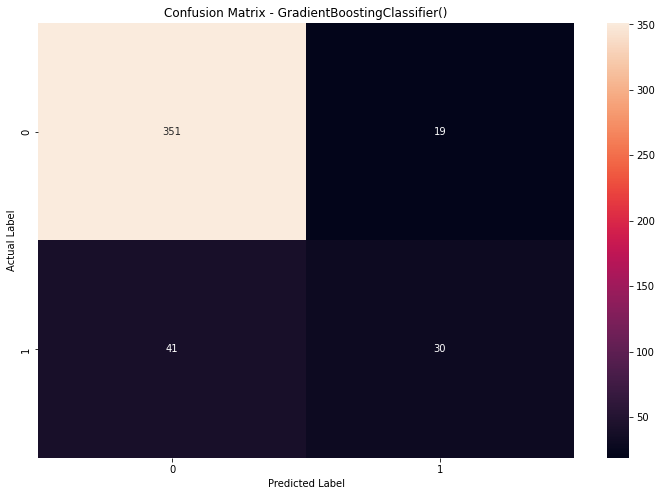

In [ ]:
predict(gradientboosting)

#### XGBoost

Accuracy: 87.76%
Precision: 68.89%
Recall: 43.66%
F1_Score: 53.45%


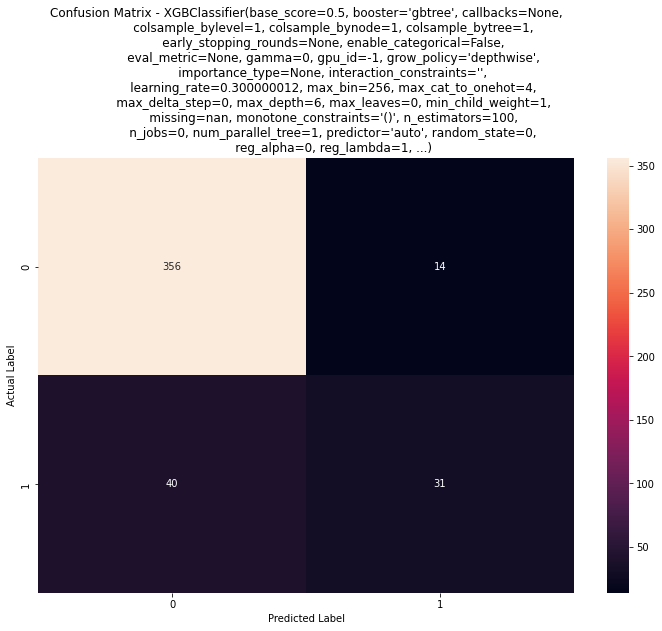

In [ ]:
predict(xgboost)

**AdaBoost Classifier had the best recall score**, correctly predicting 35 out of 62 employees who left (56.45% of them).<br><br>

Gradient Boosting had a better accuracy score (87.07%), making more correct predictions for both classes than any other model. <br><br>

Considering **the main goal to identify employees that are more likely to leave** the company, the **recall score** is the one that I'm focusing on here. I don't believe that false positives would be expensive to deal with in this case, so I want the maximum amount of true positives as possible. <br><br>

Let's use RandomSearchCV to tune our models and see if we can improve our results.<br><br>

I'll abandon the decision tree classifier since it had the worst results of them all.

## Hyperparameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Tunning Random Forest
randomforest_grid = {'n_estimators' : [100,150,200,250,300,350,400,450,500],
                    'max_depth':[5,1,15,20,25,30,40,50],
                    'criterion': ['gini','entropy'],
                    'min_samples_leaf':[2,5,8,10],
                    'min_samples_split': [2,5,8,10],
                    'max_features':['auto','sqrt']}
rf_tuning = RandomForestClassifier()
rf_search = RandomizedSearchCV(rf_tuning,param_distributions = randomforest_grid,
                              cv = 10, n_iter = 10, n_jobs = 1, verbose = 1, scoring = 'recall')
rf_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 1, 15, 20, 25, 30, 40,
                                                      50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 8, 10],
                                        'min_samples_split': [2, 5, 8, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 450,
                                                         500]},
                   scoring='recall', verbose=1)

In [ ]:
rf_search.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 40,
 'criterion': 'gini'}

Accuracy: 85.26%
Precision: 59.38%
Recall: 26.76%
F1_Score: 36.89%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

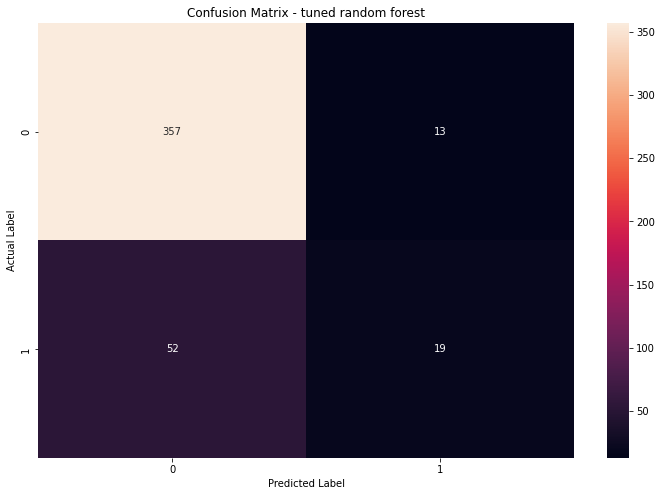

In [ ]:
tuned_rf = RandomForestClassifier(**rf_search.best_params_)
tuned_rf.fit(X_train,y_train)
y_pred = tuned_rf.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned random forest')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [ ]:
# Tuning Ada Boost
grid = {'n_estimators' : [50,100,500,1500,2000],
       'learning_rate' : [0.05,0.1,1.0,0.15,0.2,1.5,2.0],
       'algorithm': ['SAMME', 'SAMME.R']}

adaboost = RandomizedSearchCV(AdaBoostClassifier(),
                             param_distributions = grid,
                             cv = 10,
                             n_iter = 10,
                              n_jobs = 1, 
                              verbose = 1, 
                              scoring = 'recall')
adaboost.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=AdaBoostClassifier(), n_jobs=1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.05, 0.1, 1.0, 0.15,
                                                          0.2, 1.5, 2.0],
                                        'n_estimators': [50, 100, 500, 1500,
                                                         2000]},
                   scoring='recall', verbose=1)

In [ ]:
adaboost.best_params_

{'n_estimators': 1500, 'learning_rate': 0.1, 'algorithm': 'SAMME'}

Accuracy: 81.18%
Precision: 42.86%
Recall: 50.70%
F1_Score: 46.45%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

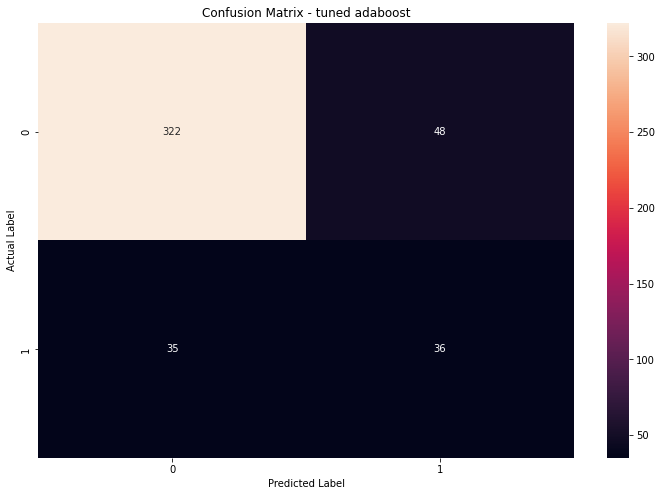

In [ ]:
tuned_adaboost = AdaBoostClassifier(**adaboost.best_params_)
tuned_adaboost.fit(X_train,y_train)
y_pred = tuned_adaboost.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned adaboost')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [ ]:
# Tuning Gradient Boosting
grid2 = {'n_estimators':[500,1000,1500,2000,2500],
        'learning_rate':[0.01,0.05,0.2,0.1,0.15,0.3,0.5],
        'min_samples_split':[2,5,6,10],
        'min_samples_leaf':[3,5,8,12],
        'criterion': ['friedman_mse', 'squared_error', 'mse'],
        'subsample': [0.1,0.2,0.5,0.6,0.8,1.0]}

gradientboosting = RandomizedSearchCV(GradientBoostingClassifier(),
                             param_distributions = grid2,
                             cv = 10,
                             n_iter = 10, n_jobs = 1, verbose=1,
                             scoring = 'recall')
gradientboosting.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse'],
                                        'learning_rate': [0.01, 0.05, 0.2, 0.1,
                                                          0.15, 0.3, 0.5],
                                        'min_samples_leaf': [3, 5, 8, 12],
                                        'min_samples_split': [2, 5, 6, 10],
                                        'n_estimators': [500, 1000, 1500, 2000,
                                                         2500],
                                        'subsample': [0.1, 0.2, 0.5, 0.6, 0.8,
                                                      1.0]},
                   scoring='recall', verbose=1)

In [ ]:
gradientboosting.best_params_

{'subsample': 0.2,
 'n_estimators': 1500,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'learning_rate': 0.05,
 'criterion': 'mse'}

Accuracy: 86.17%
Precision: 60.87%
Recall: 39.44%
F1_Score: 47.86%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

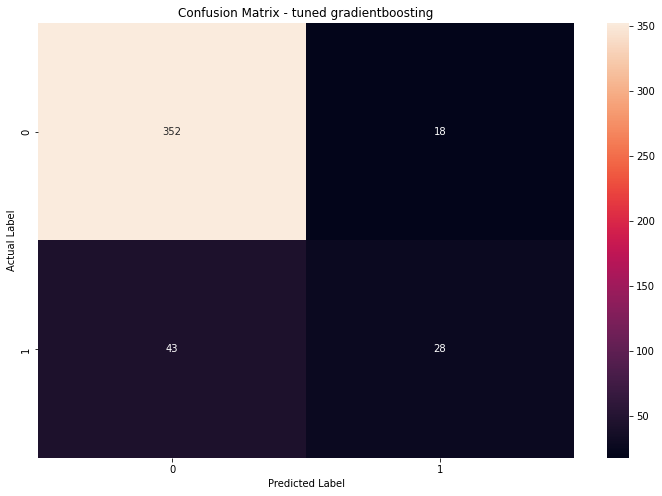

In [ ]:
tuned_gradientboosting = GradientBoostingClassifier(**gradientboosting.best_params_)
tuned_gradientboosting.fit(X_train,y_train)
y_pred = tuned_gradientboosting.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned gradientboosting')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

In [ ]:
# Tuning XGBoost Classifier
grid3 = {'n_estimators': [100,150,200,250,300,350,400,450,500],
              'learning_rate': [0.01, 0.5,0.2, 1.0],
              'subsample': [0.3,0.5, 0.6,0.8,1.0],
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': [0.2,0.5, 0.4,0.8,1.0],
              'min_child_weight': [1, 2, 3, 4]}
xgb = RandomizedSearchCV(XGBClassifier(),
                             param_distributions = grid3,
                             cv = 10,
                             n_iter = 10, n_jobs = 1, verbose=1,
                             scoring = 'recall')
xgb.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None...
                                           num_parallel_tree=None,
                                           predictor=None, random_state

In [ ]:
xgb.best_params_

{'subsample': 0.6,
 'n_estimators': 350,
 'min_child_weight': 4,
 'max_depth': 7,
 'learning_rate': 1.0,
 'colsample_bytree': 0.4}

Accuracy: 82.99%
Precision: 47.14%
Recall: 46.48%
F1_Score: 46.81%


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

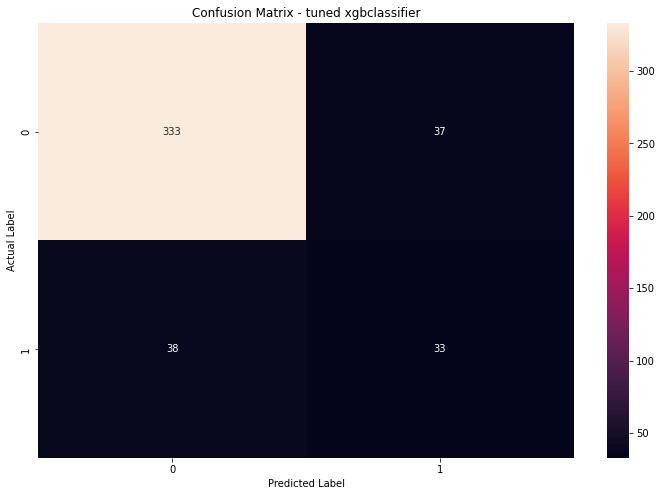

In [ ]:
tuned_xgb = XGBClassifier(**xgb.best_params_)
tuned_xgb.fit(X_train,y_train)
y_pred = tuned_xgb.predict(X_test)
print('Accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100 ))
print('Precision: %.2f%%' % (precision_score(y_test, y_pred) * 100))
print('Recall: %.2f%%' % (recall_score(y_test, y_pred) * 100))
print('F1_Score: %.2f%%' % (f1_score(y_test, y_pred) * 100))
confusion_matrix_model = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.heatmap(confusion_matrix_model, annot=True, fmt='g', ax = ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title('Confusion Matrix - tuned xgbclassifier')
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

# Conclusion <br><br>

Through RandomizedSearchCV, we could improve the accuracy score for the Gradient Boosting Classifier, scoring 88.66%, the highest among all models. <br><br>

Yet, the original Ada Boost Classifier model maintained the best recall score of 56.45%, correctly predicting the largest amount of employees who were more likely to leave. <br><br>

Again, I believe that in this case, false positives wouldn't be much more expensive than false negatives, so I'm more interested in the model that predicted the largest amount of employees to leave, which was the first Ada Boost model built.<br><br>

I hope you liked this project. Please, don't hesitate to upvote if you liked it, and don't hesitate in leaving suggestions and recommendations in the comment section. I learn a lot from the interaction and exchange of ideas that usually happens when I read comments on other's notebooks :)<br><br>

Thank you!<br><br>

*Luís Fernando Torres*
